In [81]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import datetime as dt

In [82]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [83]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta

In [84]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [85]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine) 

In [86]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [106]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [107]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [89]:
# Find the most recent date in the data set. ('2017-08-23',)
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


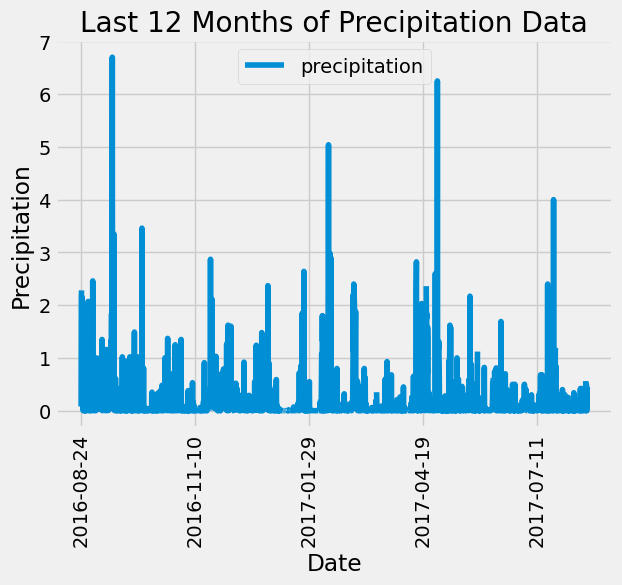

In [93]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

#  Calculate the date one year from the most recent date
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

#  Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).order_by(Measurement.date).all()

# Convert the query results to a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the DataFrame by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Last 12 Months of Precipitation Data')

# Rotate the x-axis labels 90 degrees 
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [95]:
# Calculate additional summary statistics for precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [98]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station.distinct())).scalar()
print(total_stations)

9


In [108]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = session.query(
    Measurement.station, 
    func.count(Measurement.station).label('count')
).group_by(Measurement.station).all()

station_count = sorted(station_count, key=lambda x: x[1], reverse = True)

# print statement 
for Station, count in station_count:
    print(f"Station: {Station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [116]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# select the most active station
most_active_station = station_count[0][0]

# Query to calculate the lowest, highest, and average temperature
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Print the most active station
print(f"Most Active Station: {most_active_station}")

# Print the temperature statistics
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp:.2f}")

Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


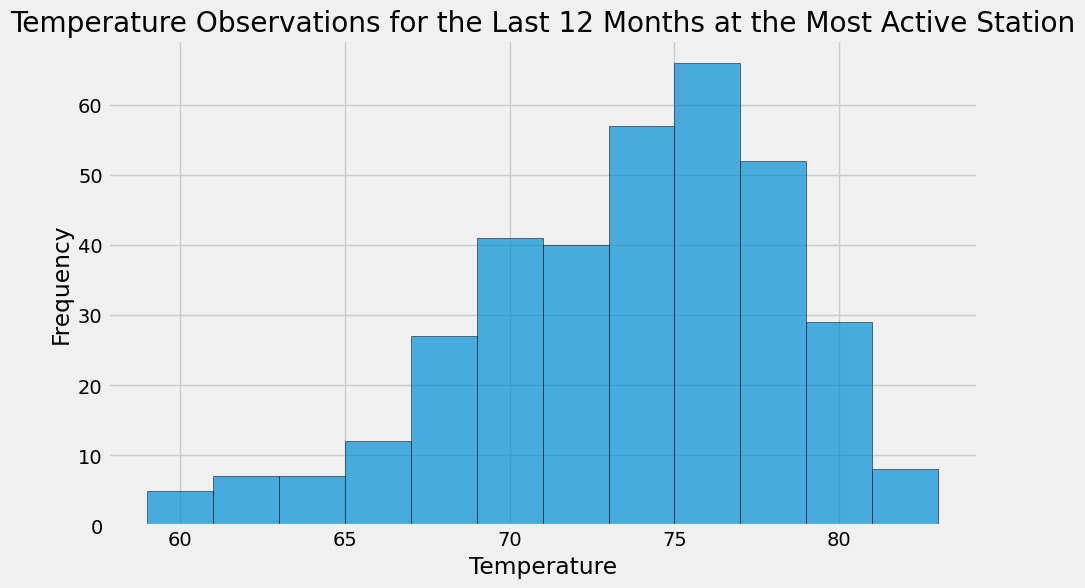

In [118]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station,
    Measurement.date >= one_year_ago
).all()

# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['temperature'])

# Step 3: Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['temperature'], bins=12, edgecolor='k', alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations for the Last 12 Months at the Most Active Station')
plt.show()

# Close Session

In [119]:
# Close Session
session.close()